# Projet 9 - Prédisez la demande en électricité

## Nettoyage des données

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.statespace.sarimax import *

from statsmodels.stats.diagnostic import acorr_ljungbox

import scipy.stats as stats

from pandas.plotting import register_matplotlib_converters

import warnings
import itertools
from time import time

In [2]:
conso = pd.read_csv("données/equilibre-national-mensuel-prod-conso-brute.csv", sep=';', parse_dates=[0])
dju = pd.read_excel("données/calcul_DJU_04_05_2022.xlsx")

C:\Users\maxim\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [3]:
dju_2 = dju.tail(14)
dju_2 = dju_2.reset_index()
dju_2 = dju_2.iloc[: , 1:]
dju_2.at[0,'Export DJU 04/05/2022'] = "Year"

dju_3 = dju_2.rename(columns=dju_2.iloc[0])
dju_3 = dju_3.tail(13)

dju_4 = dju_3.drop('Total', axis=1)
dju_4.columns = ['annee', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
dju_4 = pd.melt(dju_4, id_vars='annee', var_name='mois', value_name='dju')

dju_4['date'] = pd.to_datetime(dju_4['annee'].astype(str) + '-' + dju_4['mois'], format='%Y-%m')
#dju_4 = dju_4.drop(['annee', 'mois'], axis=1)
dju_4 = dju_4.sort_values(by = "date")
dju_5 = dju_4.loc[dju_4['dju'] != 0]

dju_test = dju_5
#dju_test["Mois"] = dju_test["annee"].astype(str) + dju_test["mois"].astype(str)
dju_test["annee"] = dju_test["annee"].astype(str)
dju_test["mois"] = dju_test["mois"].astype(str)
dju_test["Mois"] = dju_test[['annee', 'mois']].agg('-'.join, axis=1)

dju_test["Mois"] = pd.to_datetime(dju_test["Mois"])
dju_test["Mois"] = pd.to_datetime(dju_test["Mois"])

C:\Users\maxim\AppData\Local\Temp\ipykernel_13580\3368846752.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dju_test["annee"] = dju_test["annee"].astype(str)
C:\Users\maxim\AppData\Local\Temp\ipykernel_13580\3368846752.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dju_test["mois"] = dju_test["mois"].astype(str)
C:\Users\maxim\AppData\Local\Temp\ipykernel_13580\3368846752.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [4]:
conso = conso.sort_values(by = "Mois")
conso = conso.set_index('Mois')
dju_test = dju_test.set_index('Mois')
data = pd.merge(conso, dju_test, on = 'Mois')

data = data[["Consommation brute (GWh)", "dju"]]
data = data.rename(columns={'Consommation brute (GWh)' : 'conso_GWh'})
data['dju'] = pd.to_numeric(data['dju'])

Text(0.5, 1.0, 'DJU')

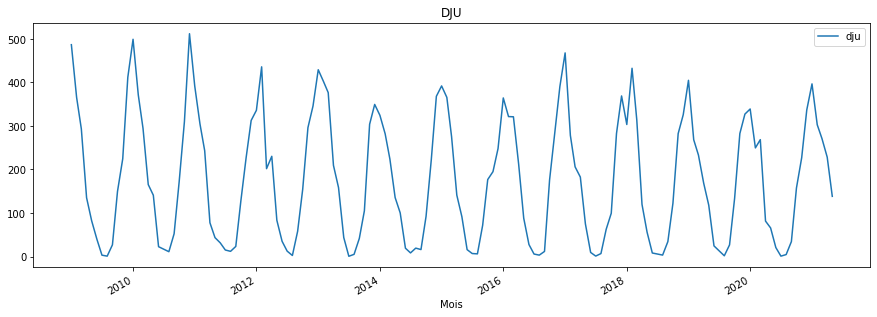

In [5]:
data.plot(y = "dju", figsize=(15,5))
plt.title('DJU')

Text(0.5, 1.0, 'Conso en GWh')

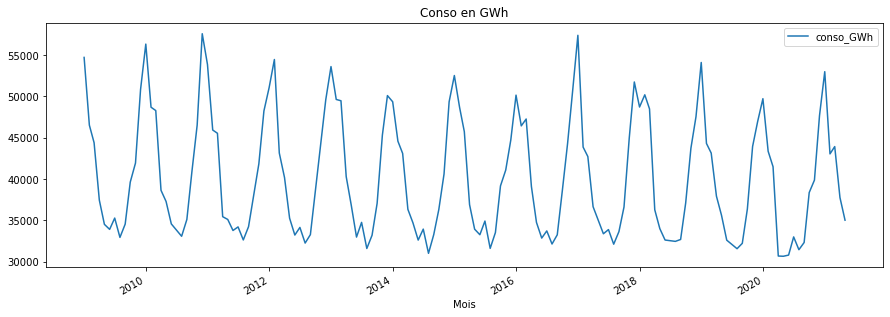

In [6]:
data.plot(y = "conso_GWh", figsize=(15,5))
plt.title('Conso en GWh')

## Mission 1 - Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.

Text(0, 0.5, 'Consommation(GWh)')

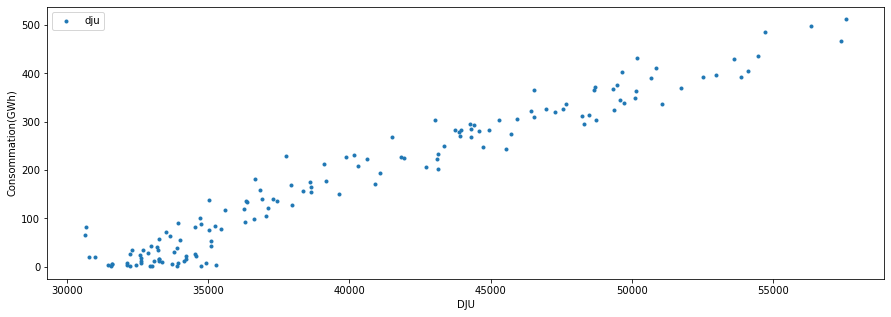

In [7]:
data.plot(x='conso_GWh', y='dju', style='.', figsize=(15,5))
plt.xlabel('DJU')
plt.ylabel('Consommation(GWh)')

On observe une relation de corrélation linéaire forte entre les deux variables 

In [8]:
reg_results = smf.ols('conso_GWh~dju', data=data).fit()
print(reg_results.summary())

                            OLS Regression Results                            
Dep. Variable:              conso_GWh   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     2590.
Date:                Tue, 31 May 2022   Prob (F-statistic):           6.19e-94
Time:                        08:06:52   Log-Likelihood:                -1288.6
No. Observations:                 146   AIC:                             2581.
Df Residuals:                     144   BIC:                             2587.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.149e+04    220.415    142.859      0.0

Text(0, 0.5, "consommation d'électricité en GWh")

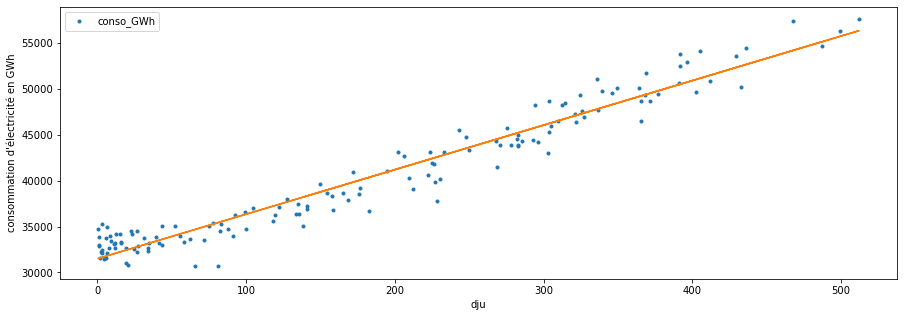

In [9]:
#Plot de la droite de régression
data.plot(x='dju', y='conso_GWh', style='.', figsize=(15,5))
plt.plot(data['dju'], reg_results.predict(sm.add_constant(data['dju'])))
plt.xlabel('dju'); plt.ylabel("consommation d'électricité en GWh")

C:\Users\maxim\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


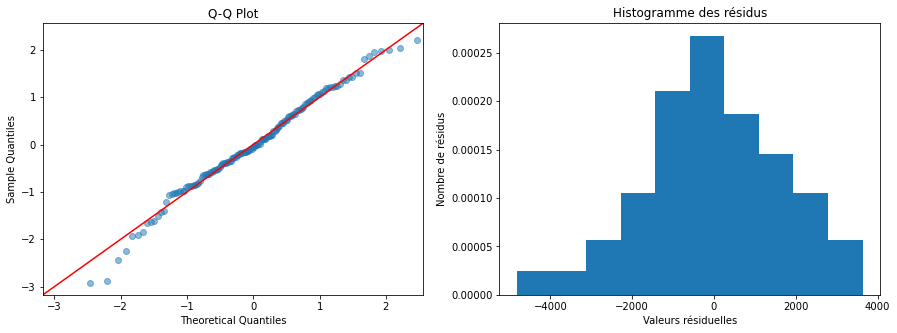

In [10]:
#Distribution des résidus
fig, ax = plt.subplots(1, 2, figsize=(15,5))

plt.hist(reg_results.resid, density=True)

model_norm_residuals = reg_results.get_influence().resid_studentized_internal
QQ = sm.ProbPlot(model_norm_residuals)
QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', ax=ax[0])

ax[0].set_title('Q-Q Plot')
ax[1].set_title('Histogramme des résidus')
ax[1].set_xlabel('Valeurs résiduelles')
ax[1].set_ylabel('Nombre de résidus')
                
plt.show()

In [11]:
stats.shapiro(reg_results.resid)

ShapiroResult(statistic=0.9886175394058228, pvalue=0.27972275018692017)

1- Les résidus semblent gaussiens </br>
2- la p-value du test de Shapiro est non significative : l'échantillon suit donc une loi normale </br>
3- Le modèle affiche un R^2 = 0.947, c'est à dire que la température (DJU, degrès jours unifié) explique 95% de la consommation d'électricité. En toute logique, les 5% restant sont dédiés à d'autres usages.

<AxesSubplot:xlabel='Mois'>

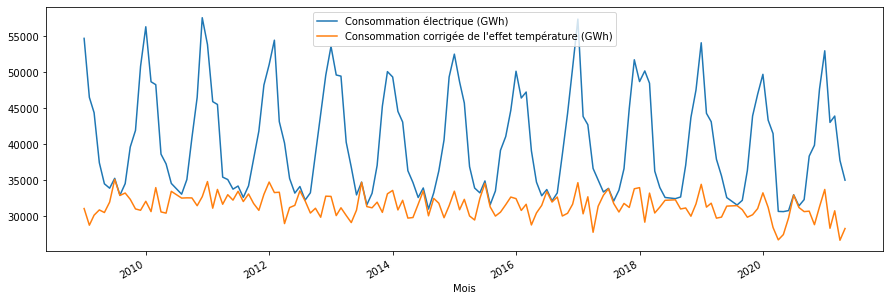

In [12]:
#Correction de la consommation par : 1) application du coef dju au dju et 2)soustraction à la conso
data['conso_corr'] = data['conso_GWh'] - data['dju'] * reg_results.params['dju']

data.plot(y = ['conso_GWh', 'conso_corr'], 
          label=["Consommation électrique (GWh)", "Consommation corrigée de l'effet température (GWh)"],
          figsize=(15,5))

L'amplitude de la série corrigée est plus faible mais des cycles apparaissent encore.

In [13]:
data.to_csv("données/data_p9.csv", index=True)

In [14]:
data = pd.read_csv("données/data_p9.csv")
data['Mois'] = pd.to_datetime(data['Mois'])
data = data.set_index('Mois')

## Mission 2 - Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.

Une moyenne mobile est une combinaison linéaire d'instants passés et futurs de la série temporelle. 
Une correction consiste à appliquer une ou plusieurs moyennes mobiles afin de mettre en évidence, estimer, les différentes composantes d'une série temporelle.
L'enjeu est de trouver une moyenne mobile qui laisse la tendance invariante, qui absorbe la saisonnalité et qui réduit le résidu.
La saisonnalité peut ensuite être estimée en travaillant sur la différence entre la série et la tendance ainsi estimée.

In [15]:
# https://moncoachdata.com/blog/modele-arima-avec-python/

def get_stationarity(timeseries):
    
    #Statistiques mobiles
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    #tracé statistiques mobiles
    original = plt.plot(timeseries, color = "blue", label = "Série d'origine")
    mean = plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
    std = plt.plot(rolling_std, color = 'black', label = 'Ecart-type mobile')
    plt.legend(loc = "best")
    plt.title('Moyenne et écart-type mobiles')
    plt.show(block = False)
    
    #Test Dickey-Fuller:
    result = adfuller(data['conso_corr'])
    print('Statistiques ADF : {}'.format(result[0]))
    print('p-value : {}'.format(result[1]))
    print('Valeurs critiques:')
    for key, value in result[4].items():
        print('\t{} : {}'.format(key, value))

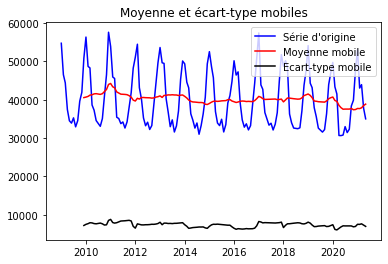

Statistiques ADF : -0.33215745040513145
p-value : 0.9208247796594364
Valeurs critiques:
	1% : -3.480118600110386
	5% : -2.8833618426136196
	10% : -2.578407034974382


In [16]:
get_stationarity(data["conso_GWh"])

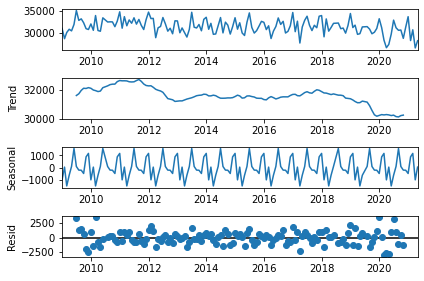

In [17]:
#https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
series = data[['conso_corr']]
result_add = seasonal_decompose(series, model='additive', period=12)
result_add.plot()
plt.show()

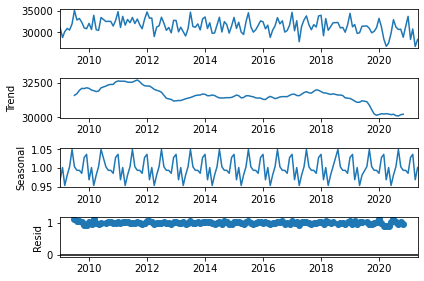

In [18]:
series = data[['conso_corr']]
result_mult = seasonal_decompose(series, model='multiplicative', period=12)
result_mult.plot()

plt.show()

L'amplitude des variations n'augmente pas avec le temps, le modèle additif peut être conservé. On confirme avec l'observation des résidus, plus cohérente que celle du modèle multiplicatif.

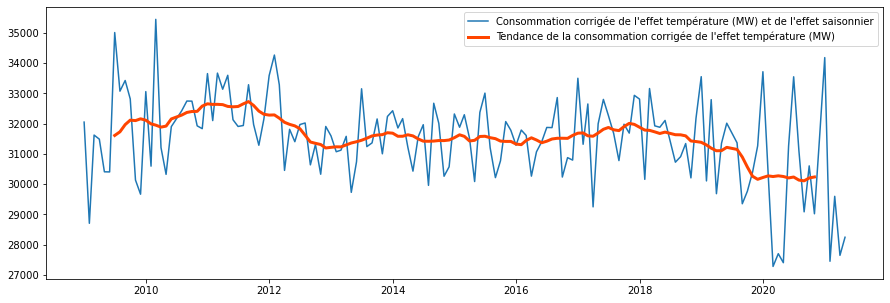

In [19]:
plt.figure(figsize=(15,5))

# consommation corrigée de l'effet température
#plt.plot(data_test['conso_corr'], label="Consommation corrigée de l'effet température (MW)")

# consommation corrigée de l'effet température et des variations saisonières
plt.plot(data['conso_corr'] - result_add.seasonal, 
         label="Consommation corrigée de l'effet température (MW) et de l'effet saisonnier")

# tendance de la consommation corrigée de l'effet température
plt.plot(result_add.trend, label="Tendance de la consommation corrigée de l'effet température (MW)", color = 'orangered', linewidth = 3)

plt.legend()

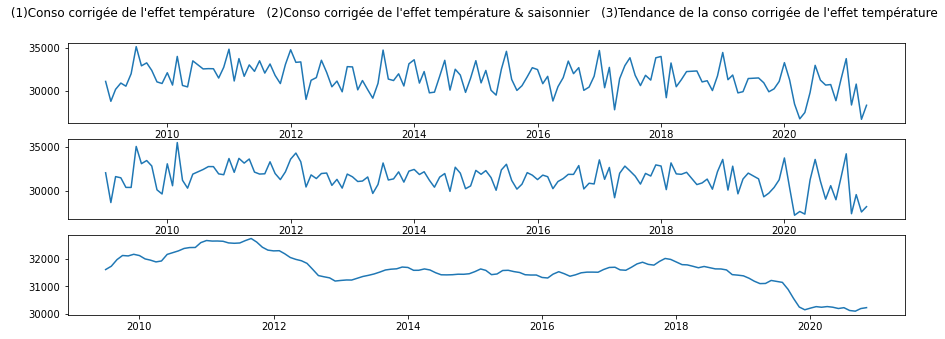

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15,5))

fig.suptitle(" (1)Conso corrigée de l'effet température   (2)Conso corrigée de l'effet température & saisonnier   (3)Tendance de la conso corrigée de l'effet température")
ax1.plot(data['conso_corr'], label="Consommation corrigée de l'effet température (MW)")
ax2.plot(data['conso_corr'] - result_add.seasonal, label="Consommation corrigée de l'effet température (MW) et de l'effet saisonnier")
ax3.plot(result_add.trend, label="Tendance de la consommation corrigée de l'effet température (MW)")

## Mission 3 - Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle.

Définition des paramètres du modèle

In [21]:
duree_pred = 12
tronc = duree_pred
df = data['conso_corr']
df_tronc = df[:-tronc]
df_a_prevoir = df[-tronc:]

Définition des formules RMSE & MAPE

In [22]:
def rmse(serie1, serie2):
    return np.sqrt(((serie1-serie2)**2).mean())

def mape(serie1, serie2):
    return (np.abs(1-serie1/serie2)).mean()*100

### Holt Winters

#### Première étape : préparation du modèle, prédiction et index des dates

In [23]:
# création du modèle
HW_mod_2 = ExponentialSmoothing(np.asarray(df), seasonal_periods=12, trend='additive', seasonal='additive').fit()

# prédiction
HW_pred_2 = HW_mod_2.forecast(duree_pred)

# on ajoute en index les dates correspondantes aux prédictions
HW_pred_2 = pd.Series(HW_pred_2, index = pd.date_range(df.index.max(), periods=duree_pred, freq='M'))

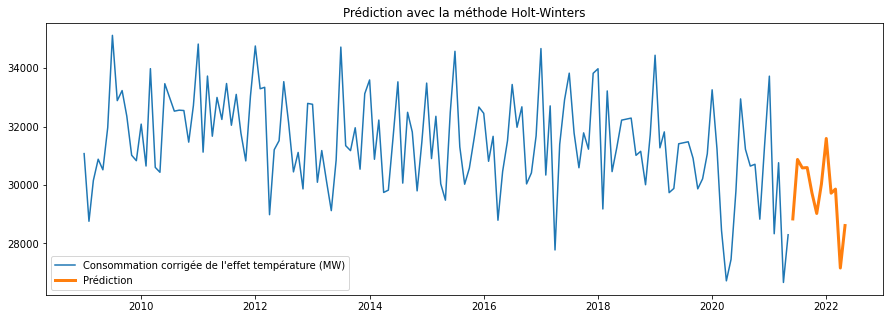

In [24]:
#Tracé de la figure
plt.figure(figsize=(15,5))
plt.plot(df, label="Consommation corrigée de l'effet température (MW)")
plt.plot(HW_pred_2, label='Prédiction', linewidth=3)
plt.title('Prédiction avec la méthode Holt-Winters')
_ =plt.legend()

#### Puis vérification a posteriori sur les données de l'année passée

In [25]:
#Création du modèle sur le dataframe tronqué de 12 mois
HW_mod_1 = ExponentialSmoothing(np.asarray(df_tronc), seasonal_periods=12, trend='additive', seasonal='additive').fit()

In [26]:
#Prédiction & indexage
HW_pred_1 = HW_mod_1.forecast(duree_pred)
HW_pred_1 = pd.Series(HW_pred_1, index = df_a_prevoir.index)

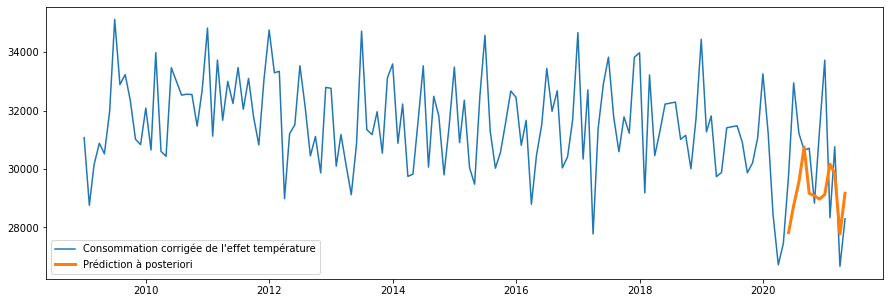

In [27]:
#Figure
plt.figure(figsize=(15,5))
plt.plot(df, label="Consommation corrigée de l'effet température")
plt.plot(HW_pred_1, label='Prédiction à posteriori', linewidth=3)
plt.legend()

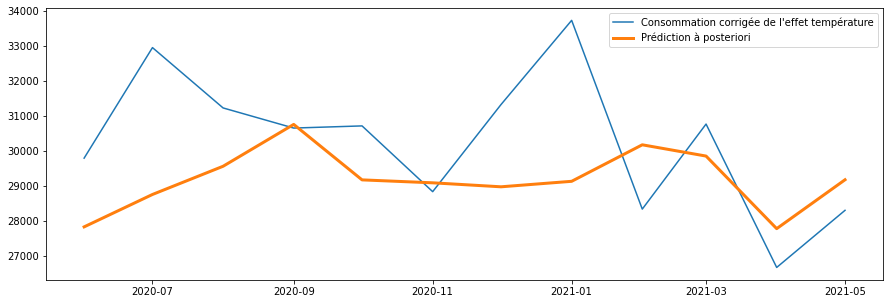

In [28]:
#Zoom sur les 12 derniers mois
plt.figure(figsize=(15,5))
plt.plot(df[-12:], label="Consommation corrigée de l'effet température")
plt.plot(HW_pred_1.iloc[-12:], label='Prédiction à posteriori', linewidth=3)
plt.legend()

#### Performance du modèle

In [29]:
print('RMSE :', (round(rmse(df_a_prevoir, HW_pred_1), 4)), 
      '\n', 'MAPE:', (round(mape(df_a_prevoir, HW_pred_1), 4)))

RMSE : 2228.2216 
 MAPE: 6.1526


## Méthode SARIMA

In [30]:
#Rappel des paramètres
duree_predite = 12
troncature = duree_predite
y = data['conso_corr']
y_tronc = y[:-troncature]
y_a_prevoir = y[-troncature:]

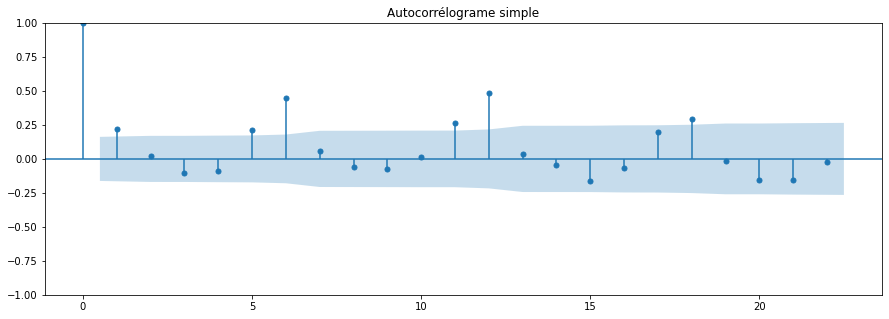

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(y, ax=ax)
plt.title('Autocorrélograme simple')
plt.show()

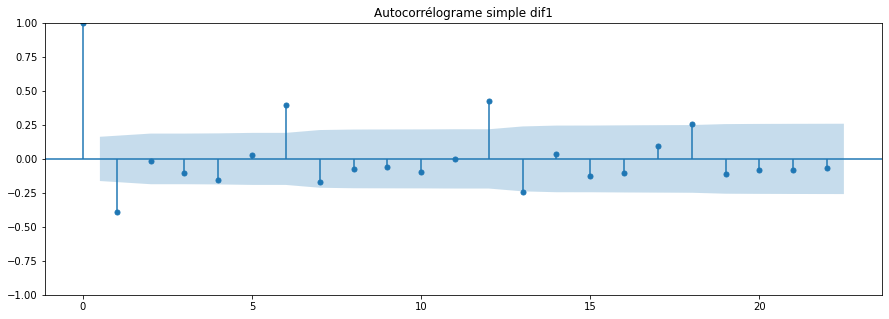

In [32]:
y_dif1 = (y - y.shift(1)).dropna()
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(y_dif1, ax=ax)
plt.title('Autocorrélograme simple dif1')
plt.show()

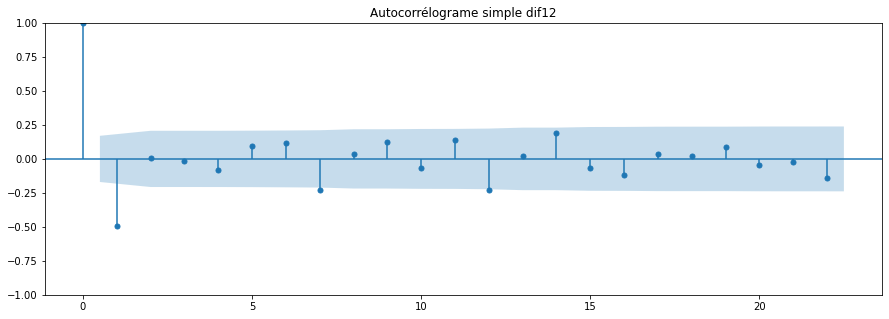

In [33]:
y_dif2 = (y_dif1 - y_dif1.shift(12)).dropna()
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(y_dif2, ax=ax)
plt.title('Autocorrélograme simple dif12')
plt.show()

In [34]:
%%time
# toute les combinaisons de p, d et q
pdq_list = list(itertools.product(range(3),
                             range(2), 
                             range(3)
           ))
# toute les combinaisons de P, D et Q
PDQ_list = [ (*val, 12) for val in list(itertools.product(
                            range(3), 
                            range(2), 
                            range(3))
            )]

# nombre de configurations
n = len(pdq_list) * len(PDQ_list)


grid_search_result = pd.DataFrame({'modele':[], 'AIC':[], 'BIC':[], 'rmse':[], 'mape':[], 'pvalue':[]})
counter = 1
s_time = time()

for pdq in pdq_list:
    for PDQ in PDQ_list:
        try:
            # calcul du modèle sur y_tronc
            mod = SARIMAX(np.asarray(y_tronc),
                          order = pdq,
                          seasonal_order = PDQ,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            result = mod.fit()
            
             
            # on fait une prédiction sur 1 ans
            prediction = result.get_forecast(duree_predite).predicted_mean
           
            # on stocke l'AIC, le BIC le RMCE et le MAPE de ce modèle
            grid_search_result = grid_search_result.append({'modele':f"{pdq}x{PDQ}", 
                            'AIC':result.aic, 
                            'BIC':result.bic,
                            'rmse': rmse(y_a_prevoir, prediction),
                            'mape': mape(y_a_prevoir, prediction),
                            'pvalue': result.pvalues.min()},
                            ignore_index=True)
        except:
            continue
            clear_output(' ')
            print(f"{counter}/{n} - {time() - s_time:.0f}s")
            counter += 1

<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from panda

<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from panda

<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from panda

<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\maxim\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\maxim\anaconda3\

<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from panda

C:\Users\maxim\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\maxim\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\maxim\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from panda

CPU times: total: 8min 6s
Wall time: 3min


<timed exec>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [35]:
grid_search_result_filter = grid_search_result[grid_search_result['pvalue'] < 0.05]
#Utilisation de la fonction .rank() pour déterminer la position de chaque modèle selon la minimisation AIC / BIC
grid_search_result_filter['rank_aic'] = grid_search_result_filter['AIC'].rank(ascending=True)
grid_search_result_filter['rank_bic'] = grid_search_result_filter['BIC'].rank(ascending=True)
grid_search_result_filter['rank_RMSE'] = grid_search_result_filter['rmse'].rank(ascending=True)
grid_search_result_filter['rank_MAPE'] = grid_search_result_filter['mape'].rank(ascending=True)

C:\Users\maxim\AppData\Local\Temp\ipykernel_13580\181460559.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid_search_result_filter['rank_aic'] = grid_search_result_filter['AIC'].rank(ascending=True)
C:\Users\maxim\AppData\Local\Temp\ipykernel_13580\181460559.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid_search_result_filter['rank_bic'] = grid_search_result_filter['BIC'].rank(ascending=True)
C:\Users\maxim\AppData\Local\Temp\ipykernel_13580\181460559.py:5: SettingWithCopyWarning: 
A value i

In [36]:
grid_search_result_filter['total'] = grid_search_result_filter['rank_aic']+grid_search_result_filter['rank_bic']+grid_search_result_filter['rank_RMSE']+grid_search_result_filter['rank_MAPE']
grid_search_result_filter['rank_total'] = grid_search_result_filter['total'].rank(ascending=True)

C:\Users\maxim\AppData\Local\Temp\ipykernel_13580\2154928379.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid_search_result_filter['total'] = grid_search_result_filter['rank_aic']+grid_search_result_filter['rank_bic']+grid_search_result_filter['rank_RMSE']+grid_search_result_filter['rank_MAPE']
C:\Users\maxim\AppData\Local\Temp\ipykernel_13580\2154928379.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid_search_result_filter['rank_total'] = grid_search_result_filter['total'].rank(ascending=Tru

In [37]:
grid_search_result_filter.sort_values('rank_total', ascending=True)

,modele,AIC,BIC,rmse,mape,pvalue,rank_aic,rank_bic,rank_RMSE,rank_MAPE,total,rank_total
267,"(2, 0, 2)x(2, 1, 0, 12)",1657.083664,1675.034101,1519.190259,3.621294,6.278887e-56,33.0,35.0,60.0,28.0,156.0,1.0
232,"(2, 0, 0)x(2, 1, 1, 12)",1663.054546,1678.440635,1605.962942,4.026685,2.980794e-11,38.0,39.0,91.0,72.0,240.0,2.0
142,"(1, 0, 1)x(2, 1, 1, 12)",1681.671751,1697.120017,1563.901345,3.928399,5.650464e-12,61.0,62.0,70.0,62.0,255.0,3.0
17,"(0, 0, 0)x(2, 1, 2, 12)",1688.790060,1701.663615,1557.160216,3.833388,7.147455e-09,68.0,70.0,68.0,53.0,259.0,4.0
5,"(0, 0, 0)x(0, 1, 2, 12)",1679.165457,1686.889590,1604.230619,3.935866,1.628166e-16,56.0,52.0,89.0,63.0,260.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
37,"(0, 0, 2)x(0, 0, 1, 12)",2700.022632,2711.139126,16601.105706,126.120994,0.000000e+00,315.0,315.0,319.0,319.0,1268.0,318.0
19,"(0, 0, 1)x(0, 0, 1, 12)",2727.012995,2735.375470,16690.304045,125.646585,0.000000e+00,317.0,317.0,320.0,318.0,1272.0,319.0
1,"(0, 0, 0)x(0, 0, 1, 12)",2771.320937,2776.912518,15850.830001,111.755446,0.000000e+00,320.0,320.0,317.0,317.0,1274.0,320.0
36,"(0, 0, 2)x(0, 0, 0, 12)",2976.731729,2985.357321,28677.093104,inf,0.000000e+00,321.0,321.0,321.0,321.5,1284.5,321.0


In [38]:
#On entre les paramètres obtenus dans le modèle
SARIMA_mod_tronc = SARIMAX(np.asarray(df_tronc), 
                       order=(2,0,2), 
                       seasonal_order=(2,1,0,12), 
                       enforce_invertibility=False, 
                       enforce_stationarity=False)
sarima_res_tronc = SARIMA_mod_tronc.fit()
print(sarima_res_tronc.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  134
Model:             SARIMAX(2, 0, 2)x(2, 1, [], 12)   Log Likelihood                -821.542
Date:                             Tue, 31 May 2022   AIC                           1657.084
Time:                                     08:09:59   BIC                           1675.034
Sample:                                          0   HQIC                          1664.340
                                             - 134                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4117      0.057      7.246      0.000       0.300       0.523
ar.L2         -0.8959      

C:\Users\maxim\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


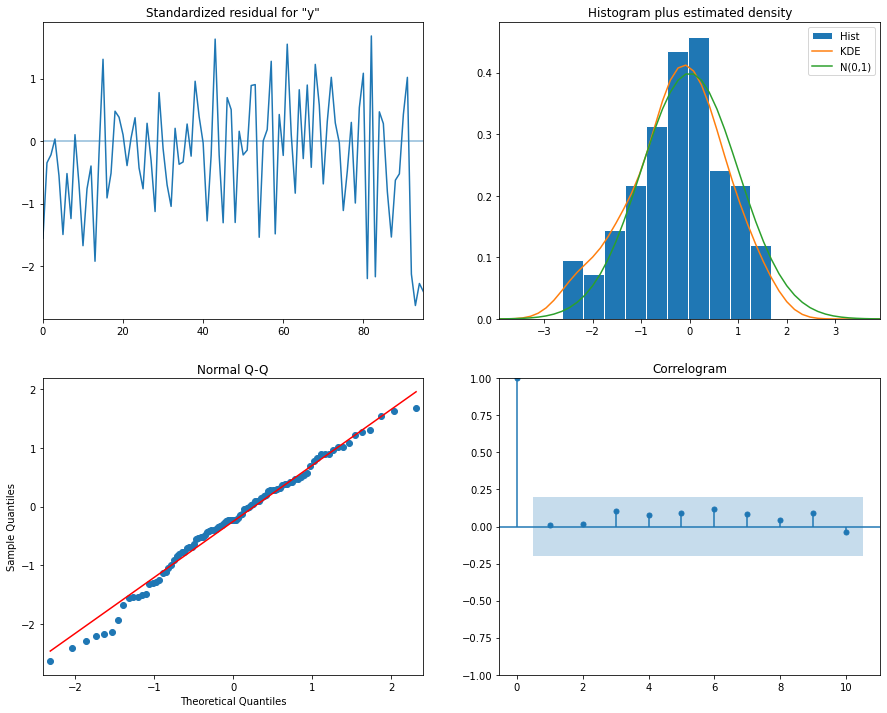

In [39]:
sarima_res_tronc.plot_diagnostics(figsize=(15, 12))
plt.show()

In [40]:
for elt in [6,12,18,24,36]:
    print("{}:{}".format(elt, sm.stats.acorr_ljungbox(sarima_res_tronc.resid, lags=elt).mean()))

6:lb_stat      3.412661e+02
lb_pvalue    6.525705e-27
dtype: float64
12:lb_stat      4.999468e+02
lb_pvalue    3.262853e-27
dtype: float64
18:lb_stat      5.852163e+02
lb_pvalue    2.175235e-27
dtype: float64
24:lb_stat      6.384697e+02
lb_pvalue    1.631426e-27
dtype: float64
36:lb_stat      6.963251e+02
lb_pvalue    1.087618e-27
dtype: float64


#### Prédiction sur les données passées

In [41]:
sarima_pred_tronc = sarima_res_tronc.get_forecast(duree_pred)
sarima_pred_tronc_fig = pd.DataFrame(sarima_pred_tronc.predicted_mean, index = df_a_prevoir.index)

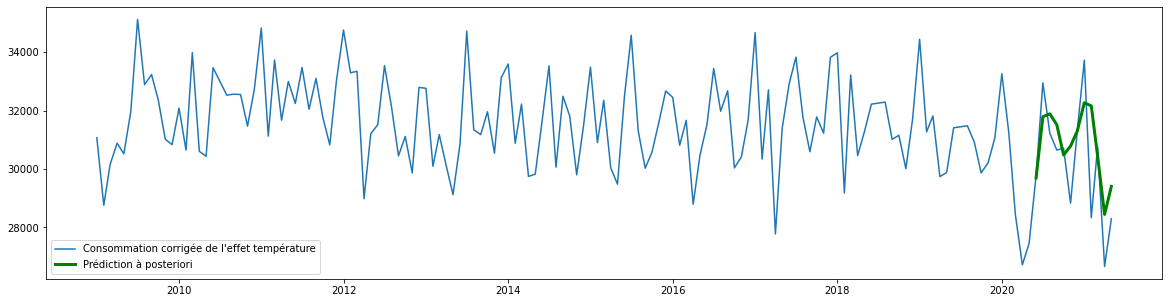

In [42]:
#Figure
plt.figure(figsize=(20,5))
plt.plot(df, label="Consommation corrigée de l'effet température")
plt.plot(sarima_pred_tronc_fig, 'g', label='Prédiction à posteriori', linewidth=3)
plt.legend()

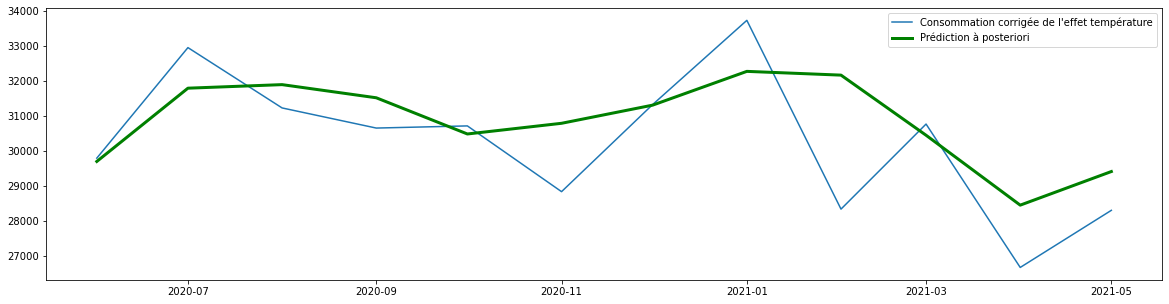

In [43]:
#Zoom sur les 12 derniers mois
plt.figure(figsize=(20,5))
plt.plot(df[-12:], label="Consommation corrigée de l'effet température")
plt.plot(sarima_pred_tronc_fig.iloc[-12:], 'g', label='Prédiction à posteriori', linewidth=3)
plt.legend()

In [44]:
print('RMSE :', (round(rmse(df_a_prevoir, sarima_pred_tronc_fig.squeeze()), 4)), 
      '\n', 'MAPE:', (round(mape(df_a_prevoir, sarima_pred_tronc_fig.squeeze()), 4)))

RMSE : 1519.1903 
 MAPE: 3.6213


#### Prédiction sur le futur

In [45]:
#On entre les paramètres dans le modèle
SARIMA_mod = SARIMAX(np.asarray(df), 
                       order=(2,0,2), 
                       seasonal_order=(2,1,0,12), 
                       enforce_invertibility=False, 
                       enforce_stationarity=False)
sarima_res = SARIMA_mod.fit()
print(sarima_res.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  146
Model:             SARIMAX(2, 0, 2)x(2, 1, [], 12)   Log Likelihood                -928.513
Date:                             Tue, 31 May 2022   AIC                           1871.026
Time:                                     08:10:02   BIC                           1889.801
Sample:                                          0   HQIC                          1878.639
                                             - 146                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3912      0.076      5.129      0.000       0.242       0.541
ar.L2         -0.8906      

C:\Users\maxim\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [46]:
# prédiction
sarima_pred = sarima_res.get_forecast(duree_pred)

# on créé un dataframe qui contient pour chacune des dates prédites, la valeurs et l'intervalle de confiance
prediction = pd.DataFrame(
               {'prediction': sarima_pred.predicted_mean,
                'conf_inf': [val[0] for val in sarima_pred.conf_int(alpha=0.05)],
                'conf_sup': [val[1] for val in sarima_pred.conf_int(alpha=0.05)]
               }, 
               index= pd.date_range(df.index.max(), periods=duree_pred, freq='M'))

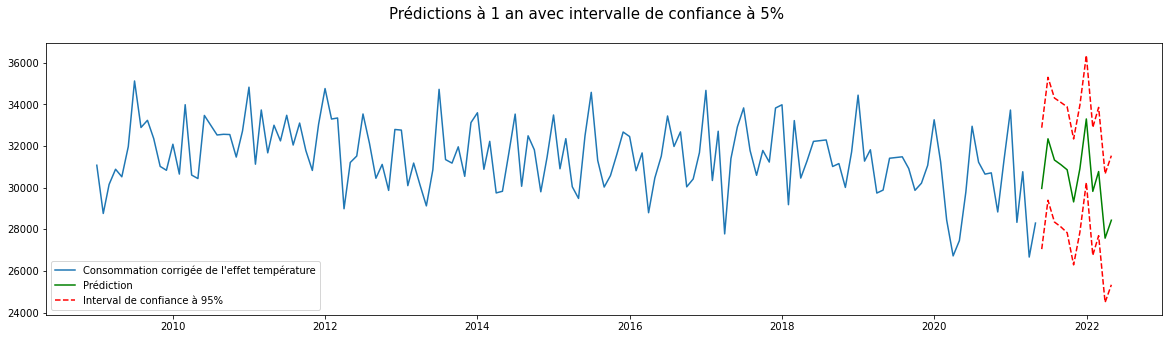

In [47]:
fig = plt.figure(figsize=(20,5))
fig.suptitle('Prédictions à 1 an avec intervalle de confiance à 5%', fontsize=15)
plt.plot(df, label="Consommation corrigée de l'effet température")
plt.plot(prediction['prediction'], 'g', label='Prédiction')
plt.plot(prediction['conf_sup'], label='Interval de confiance à 95%', color='r', linestyle='--')
plt.plot(prediction['conf_inf'], label='', color='r', linestyle='--')
plt.legend()

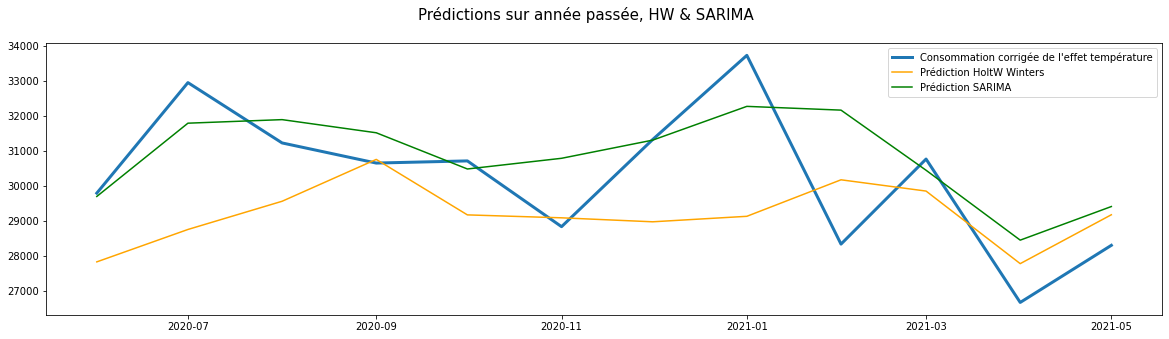

In [48]:
#Zoom sur les prédictions passées HW & SARIMA
fig = plt.figure(figsize=(20,5))
fig.suptitle('Prédictions sur année passée, HW & SARIMA', fontsize=15)
plt.plot(df[-12:], label="Consommation corrigée de l'effet température",linewidth=3)
plt.plot(HW_pred_1.iloc[-12:], color = 'orange', label='Prédiction HoltW Winters')
plt.plot(sarima_pred_tronc_fig.iloc[-12:], 'g', label='Prédiction SARIMA')
plt.legend()

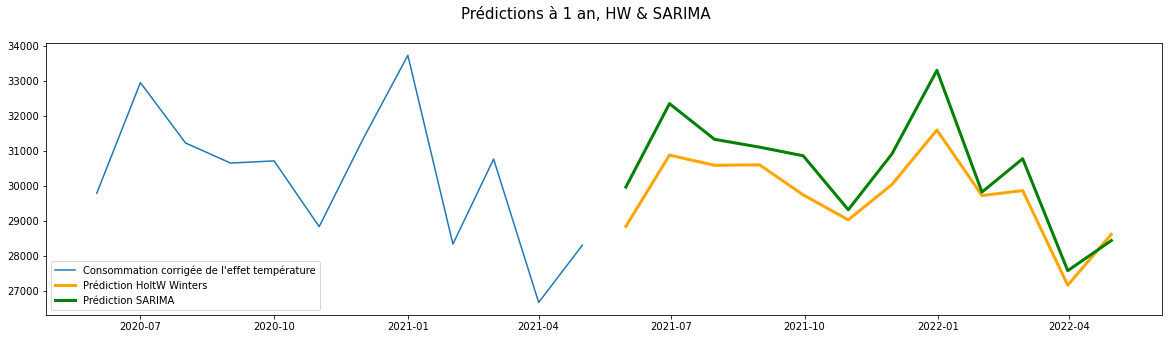

In [49]:
#Zoom sur les prédictions futures HW & SARIMA
fig = plt.figure(figsize=(20,5))
fig.suptitle('Prédictions à 1 an, HW & SARIMA', fontsize=15)
plt.plot(df[-12:], label="Consommation corrigée de l'effet température")
plt.plot(HW_pred_2.iloc[-12:], color = 'orange', label='Prédiction HoltW Winters', linewidth=3)
plt.plot(prediction['prediction'].iloc[-12:], 'g', label='Prédiction SARIMA', linewidth=3)
plt.legend()
plt.show()